<a href="https://colab.research.google.com/github/Lilchoto3/DS-Unit-1-Sprint-2-Statistics/blob/master/module2/LS_DS_122_Sampling_Confidence_Intervals_and_Hypothesis_Testing_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Assignment - Build a confidence interval

A confidence interval refers to a neighborhood around some point estimate, the size of which is determined by the desired p-value. For instance, we might say that 52% of Americans prefer tacos to burritos, with a 95% confidence interval of +/- 5%.

52% (0.52) is the point estimate, and +/- 5% (the interval $[0.47, 0.57]$) is the confidence interval. "95% confidence" means a p-value $\leq 1 - 0.95 = 0.05$.

In this case, the confidence interval includes $0.5$ - which is the natural null hypothesis (that half of Americans prefer tacos and half burritos, thus there is no clear favorite). So in this case, we could use the confidence interval to report that we've failed to reject the null hypothesis.

But providing the full analysis with a confidence interval, including a graphical representation of it, can be a helpful and powerful way to tell your story. Done well, it is also more intuitive to a layperson than simply saying "fail to reject the null hypothesis" - it shows that in fact the data does *not* give a single clear result (the point estimate) but a whole range of possibilities.

How is a confidence interval built, and how should it be interpreted? It does *not* mean that 95% of the data lies in that interval - instead, the frequentist interpretation is "if we were to repeat this experiment 100 times, we would expect the average result to lie in this interval ~95 times."

For a 95% confidence interval and a normal(-ish) distribution, you can simply remember that +/-2 standard deviations contains 95% of the probability mass, and so the 95% confidence interval based on a given sample is centered at the mean (point estimate) and has a range of +/- 2 (or technically 1.96) standard deviations.

Different distributions/assumptions (90% confidence, 99% confidence) will require different math, but the overall process and interpretation (with a frequentist approach) will be the same.

Your assignment - using the data from the prior module ([congressional voting records](https://archive.ics.uci.edu/ml/datasets/Congressional+Voting+Records)):


### Confidence Intervals:
1. Generate and numerically represent a confidence interval
2. Graphically (with a plot) represent the confidence interval
3. Interpret the confidence interval - what does it tell you about the data and its distribution?

### Chi-squared tests:
4. Take a dataset that we have used in the past in class that has **categorical** variables. Pick two of those categorical variables and run a chi-squared tests on that data
  - By hand using Numpy
  - In a single line using Scipy


In [0]:
# Import everything and get it set up 

import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np

columns=['party','handicapped-infants','water-project',
         'budget','physician-fee-freeze', 'el-salvador-aid',
         'religious-groups','anti-satellite-ban',
         'aid-to-contras','mx-missile','immigration',
         'synfuels', 'education', 'right-to-sue','crime','duty-free',
         'south-africa']

# Import data and set column headers
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data', names=columns)

df.head()

,party,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
0,republican,n,y,n,y,y,y,n,n,n,y,?,y,y,y,n,y
1,republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,?
2,democrat,?,y,y,?,y,y,n,n,n,n,y,n,y,y,n,n
3,democrat,n,y,y,n,?,y,n,n,n,n,y,n,y,n,n,y
4,democrat,y,y,y,n,y,y,n,n,n,n,y,?,y,y,y,y


In [0]:
# Clean up data to be used for statistical purposes
df = df.replace({'y':1,'n':0,'?':np.NaN})

df.head()

,party,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
0,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,0.0,1.0
1,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,NaN
2,democrat,NaN,1.0,1.0,NaN,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
3,democrat,0.0,1.0,1.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,democrat,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,1.0


In [0]:
# Confidence interval function
def conf_interval(sample, confidence=0.95):
  """
  Arguments:
    sample - list or numpy array of sample observations
    confidence - level of confidence (default 0.95)

  Returns:
    tuple of (mean, margin of error)
  """
  # Make the sample into a numpy array
  sample = np.array(sample)

  # Remove any NaN values from the array
  # Since we're dealing with votes, NaNs are abstain votes, aka, non-votes, which aren't needed
  sample = sample[~np.isnan(sample)]

  # Find mean of sample
  mean = np.mean(sample)

  # Get sample size
  n = len(sample)

  # Get standard deviation for sample data
  stddev = np.std(sample, ddof=1)/np.sqrt(n)

  # Get the T-stat that contains the confidence level of possible sample means
  t = stats.t.ppf((1+confidence)/2.0,n - 1)

  # Calculate margin of error
  moe = t * stddev

  low_bound = mean - moe
  high_bound = mean + moe

  return low_bound, mean, high_bound

In [0]:
# Calculate a confidence interval for a column

# I'm going to do the education bill as an example

# How big is my list of voters?
df['education'].shape

(435,)

In [0]:
# Okay, lets grab a sample of it and then get the confidence interval

sample1 = df['education'].sample(50)

low, mean, high = conf_interval(sample1, confidence=0.95)
print("lower bound:",low)
print("mean:",mean)
print("higher bound:", high)

lower bound: 0.20482534544770928
mean: 0.34782608695652173
higher bound: 0.4908268284653342


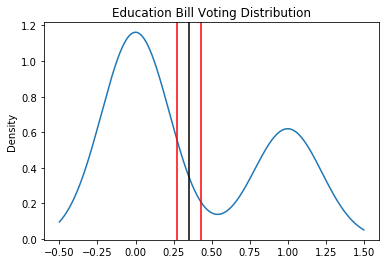

In [0]:
sample1.plot.density()
plt.title('Education Bill Voting Distribution')
plt.axvline(low, color='red')
plt.axvline(mean,color='black')
plt.axvline(high,color='red')
plt.show()

**Explanation:**

According to the data, there is a 95% confidence that a sample mean will fall within the range of .204 to .491.


This means that it is 95% likely that, if a new sample were to be gathered, that anywhere from 20.4% to 49.1% of congressmen would vote in favor of the 'education' bill.

In [0]:
# I want to test this with a few more sets of data

# Next, I'll find a 99% confident interval for democrats who voted on the 'crime' bill

sample2 = df[df['party']=='democrat']

sample2 = sample2['crime']

low, mean, high = conf_interval(sample2, confidence=0.99)
print("lower bound:",low)
print("mean:",mean)
print("higher bound:", high)

lower bound: 0.2728210577210167
mean: 0.35019455252918286
higher bound: 0.427568047337349


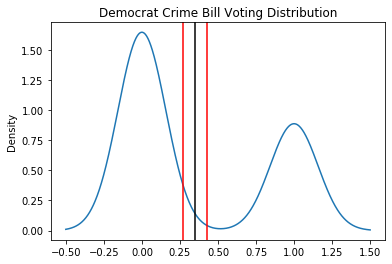

In [0]:
sample2.plot.density()
plt.title('Democrat Crime Bill Voting Distribution')
plt.axvline(low, color='red')
plt.axvline(mean,color='black')
plt.axvline(high,color='red')
plt.show()

**Explanation:**

According to this data, there is a 99% chance that a sample mean of a different sample set of this data would fall within the range of .273 to .428.

This means that, if given another sample set, the mean for Democrats voting on the 'crime' bill would be anywhere from 27.3% to 42.8% in favor of the 'crime' bill.

In [34]:
# Chi-Squared test

# In order to get chi-squared values from a data set, I'm going to be using the poker UCI dataset I used in sprint 1

# The data doesn't come with column names, so I built some myself
column_names = ["suit1", "rank1", "suit2", "rank2", "suit3", "rank3", "suit4", "rank4", "suit5", "rank5", "class"]

df2 = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/poker/poker-hand-training-true.data", names=column_names)

# I'm also going to change the way it's displayed, turn numbers into the strings they're supposed to represent.
suit_map = {1:'heart',2:'spade',3:'diamond',4:'club'}
rank_map = {1:'ace',2:'two',3:'three',4:'four',5:'five',6:'six',7:'seven',8:'eight',9:'nine',10:'ten',11:'jack',12:'queen',13:'king'}
class_map = {0:'nothing',1:'one pair',2:'two pairs',3:'three of a kind',4:'straight',5:'flush',6:'full house',7:'four of a kind',8:'straight flush',9:'royal flush'}

df2[['suit1','suit2','suit3','suit4','suit5']] = df2[['suit1','suit2','suit3','suit4','suit5']].replace(suit_map)
df2[['rank1','rank2','rank3','rank4','rank5']] = df2[['rank1','rank2','rank3','rank4','rank5']].replace(rank_map)
df2['class'] = df2['class'].replace(class_map)

df2.head()

,suit1,rank1,suit2,rank2,suit3,rank3,suit4,rank4,suit5,rank5,class
0,heart,ten,heart,jack,heart,king,heart,queen,heart,ace,royal flush
1,spade,jack,spade,king,spade,ten,spade,queen,spade,ace,royal flush
2,diamond,queen,diamond,jack,diamond,king,diamond,ten,diamond,ace,royal flush
3,club,ten,club,jack,club,ace,club,king,club,queen,royal flush
4,club,ace,club,king,club,queen,club,jack,club,ten,royal flush


In [37]:
# Create the contingency table
cont_table = pd.DataFrame(pd.crosstab(df2['suit1'], df2['rank1'], margins=True).values)
cont_table.columns = ['ace','two','three','four','five','six','seven','eight','nine','ten','jack','queen','king','total']
cont_table.index = ['heart','spade','diamond','club','total']

cont_table

,ace,two,three,four,five,six,seven,eight,nine,ten,jack,queen,king,total
heart,529,472,449,496,449,470,511,510,506,486,466,481,487,6312
spade,493,464,482,514,478,490,473,475,470,457,484,467,503,6250
diamond,455,524,466,460,488,473,462,464,476,455,479,474,474,6150
club,505,488,495,449,511,482,521,491,509,462,448,460,477,6298
total,1982,1948,1892,1919,1926,1915,1967,1940,1961,1860,1877,1882,1941,25010


In [38]:
# Grab the sums for each row
suit_sums = cont_table.iloc[0:4,13]
rank_sums = cont_table.iloc[4,0:13]

print(suit_sums)
print(rank_sums)

heart      6312
spade      6250
diamond    6150
club       6298
Name: total, dtype: int64
ace      1982
two      1948
three    1892
four     1919
five     1926
six      1915
seven    1967
eight    1940
nine     1961
ten      1860
jack     1877
queen    1882
king     1941
Name: total, dtype: int64


In [39]:
# Get the number of entries
entries_total = df2.shape[0]
entries_total

25010

In [40]:
# Here is where I will calculate the chi-squared data by hand.

# Get chi-squared expected data
expected = []
for i in range(len(suit_sums)):
  expected_row = []
  for col in rank_sums:
    expected_val = col * suit_sums[i]/entries_total
    expected_row.append(expected_val)
  expected.append(expected_row)

expected = pd.DataFrame(expected)
print(expected.shape)
expected

(4, 13)


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,500.215274,491.634386,477.501160,484.315394,486.082047,483.305878,496.429588,489.615354,494.915314,469.425030,473.715474,474.977369,489.867733
1,495.301879,486.805278,472.810876,479.558177,481.307477,478.558577,491.553379,484.806078,490.053978,464.814074,469.062375,470.311875,485.055978
2,487.377049,479.016393,465.245902,471.885246,473.606557,470.901639,483.688525,477.049180,482.213115,457.377049,461.557377,462.786885,477.295082
3,499.105798,490.543942,476.442063,483.241184,485.003918,482.233906,495.328509,488.529388,493.817593,468.383846,472.664774,473.923870,488.781208


In [41]:
# Create a crosstab of the same data without the margins
observed = pd.DataFrame(pd.crosstab(df2['suit1'], df2['rank1']).values)
print(observed.shape)
observed

(4, 13)


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,529,472,449,496,449,470,511,510,506,486,466,481,487
1,493,464,482,514,478,490,473,475,470,457,484,467,503
2,455,524,466,460,488,473,462,464,476,455,479,474,474
3,505,488,495,449,511,482,521,491,509,462,448,460,477


In [43]:
# Use array broadcasting to chi-square the observed and expected tables
chi_squared = ((observed - expected)**2/(expected)).sum()
print(f"Chi-Squared:\n{chi_squared}")

Chi-Squared:
0     3.887560
1     6.090019
2     2.603847
3     5.481101
4     4.682446
5     0.649330
6     3.430925
7     1.416481
8     1.615750
9     0.815974
10    2.547600
11    0.780459
12    0.987317
dtype: float64


In [44]:
# now to do it all in one line with scipy
chi_squared, p_value, dof, expected = stats.chi2_contingency(observed)
expected = pd.DataFrame(expected)
print(f'Chi-Squared: {chi_squared}\nP-value: {p_value}\nDegrees of Freedom: {dof}')
expected

Chi-Squared: 34.988809163056914
P-value: 0.5165315608157963
Degrees of Freedom: 36


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,500.215274,491.634386,477.501160,484.315394,486.082047,483.305878,496.429588,489.615354,494.915314,469.425030,473.715474,474.977369,489.867733
1,495.301879,486.805278,472.810876,479.558177,481.307477,478.558577,491.553379,484.806078,490.053978,464.814074,469.062375,470.311875,485.055978
2,487.377049,479.016393,465.245902,471.885246,473.606557,470.901639,483.688525,477.049180,482.213115,457.377049,461.557377,462.786885,477.295082
3,499.105798,490.543942,476.442063,483.241184,485.003918,482.233906,495.328509,488.529388,493.817593,468.383846,472.664774,473.923870,488.781208


## Stretch goals:

1. Write a summary of your findings, mixing prose and math/code/results. *Note* - yes, this is by definition a political topic. It is challenging but important to keep your writing voice *neutral* and stick to the facts of the data. Data science often involves considering controversial issues, so it's important to be sensitive about them (especially if you want to publish).
2. Apply the techniques you learned today to your project data or other data of your choice, and write/discuss your findings here.
3. Refactor your code so it is elegant, readable, and can be easily run for all issues.

## Resources

- [Interactive visualize the Chi-Squared test](https://homepage.divms.uiowa.edu/~mbognar/applets/chisq.html)
- [Calculation of Chi-Squared test statistic](https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test)
- [Visualization of a confidence interval generated by R code](https://commons.wikimedia.org/wiki/File:Confidence-interval.svg)
- [Expected value of a squared standard normal](https://math.stackexchange.com/questions/264061/expected-value-calculation-for-squared-normal-distribution) (it's 1 - which is why the expected value of a Chi-Squared with $n$ degrees of freedom is $n$, as it's the sum of $n$ squared standard normals)